# Mixture density networks

#### >Gaussian function (not all distributions are unimodal gaussian function)

#### >Visualizing model fitting with multi output data

#### >Probability distribution function

#### >Condititional probability

#### >

#### >MDN intuition and training

#### >inference sampling

## Conditional Probability

Conditional probability is the probability of one event occurring with some relationship to one or more other events. For example:

Event A is that it is raining outside, and it has a 0.3 (30%) chance of raining today.
Event B is that you will need to go outside, and that has a probability of 0.5 (50%).
A conditional probability would look at these two events in relationship with one another, such as the probability that it is both raining and you will need to go outside.

The formula for conditional probability is:
P(B|A) = P(A and B) / P(A)
which you can also rewrite as:
P(B|A) = P(A∩B) / P(A)

-> 0.3*0.5 / 0.3 = 0.5 (50%)


## How do Mixture Density RNNs Predict the Future?


### https://arxiv.org/pdf/1901.07859.pdf



In practice, a mixture density network (MDN) operates by
transforming the outputs of a neural network to form the parameters of a mixture distribution (Bishop, 1994), generally

with Gaussian models for each mixture component. These
parameters are the centres (µ) and scales (σ) for each Gaussian component, as well as a weight (π) for each component
(see Figure 1). The MDN usually uses an exponential activation function to transform the scale parameters to be positive
and non-zero. For training, the probability density function
of the mixture model is used to generate the negative log
likelihood for the loss function. This involves constructing
probability density functions (PDFs) for each Gaussian component and categorical distribution from the mixture weights
(see Appendix Section 1.4 for details). One advantage of an
MDN is that various component distributions can be used
so long as the PDF is tractable, for instance, 1D (Bishop,
1994) or 2D (Graves, 2013) Gaussian distributions, or, as in
our case, a multivariate Gaussian with a diagonal covariance
matrix.
For inference, results are sampled from the mixture distribution. First, the πs are used to form a categorical distribution
by applying the softmax function. A sample is drawn from
this distribution to determine which Gaussian component
will provide the output. The index i of the sampled π is used
to select a Gaussian distribution, N (µi
, σ2
i
), from which a
sample is drawn to provide the outcome. In some cases,
it is advantageous to adjust the diversity of sampling (for
instance, to favour unlikely predictions), in which case the
temperature of the categorical distribution can be adjusted in
the typical way, and the covariance matrices of the Gaussian
components may be scaled. We refer the these operations
as adjusting π- or σ-temperature respectively.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math

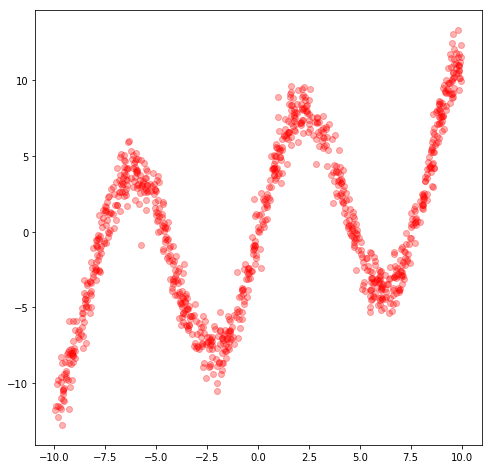

In [5]:
NSAMPLE = 1000
x_data = np.float32(np.random.uniform(-10, 10, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE,1)))
y_data = np.float32(np.sin(0.75*x_data)*7.0+x_data*0.5+r_data*1.0)

plt.figure(figsize=(8, 8))
plot_out = plt.plot(x_data,y_data,'ro',alpha=0.3)
plt.show()

In [6]:
x = tf.placeholder(dtype=tf.float32, shape=[None,1])
y = tf.placeholder(dtype=tf.float32, shape=[None,1])


In [7]:
##### 
NHIDDEN = 20
W = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=1.0, dtype=tf.float32))
b = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=1.0, dtype=tf.float32))

W_out = tf.Variable(tf.random_normal([NHIDDEN,1], stddev=1.0, dtype=tf.float32))
b_out = tf.Variable(tf.random_normal([1,1], stddev=1.0, dtype=tf.float32))

hidden_layer = tf.nn.tanh(tf.matmul(x, W) + b)
y_out = tf.matmul(hidden_layer,W_out) + b_out 

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
lossfunc = tf.nn.l2_loss(y_out-y);

In [9]:
train_op = tf.train.RMSPropOptimizer(learning_rate=0.1, decay=0.8).minimize(lossfunc)

In [15]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

In [16]:
NEPOCH = 5000
for i in range(NEPOCH):
    sess.run(train_op,feed_dict={x: x_data, y: y_data})


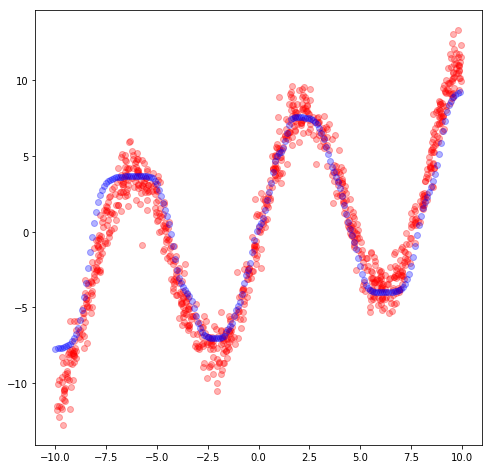

In [17]:
x_test = np.float32(np.arange(-10,10,0.1))
x_test = x_test.reshape(x_test.size,1)
y_test = sess.run(y_out,feed_dict={x: x_test})

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()

sess.close()

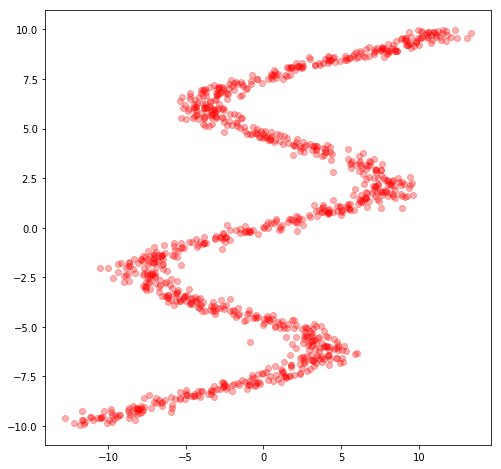

In [18]:
temp_data = x_data
x_data = y_data
y_data = temp_data

plt.figure(figsize=(8, 8))
plot_out = plt.plot(x_data,y_data,'ro',alpha=0.3)
plt.show()

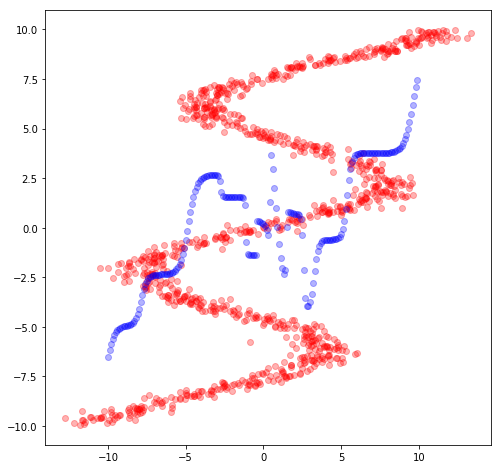

In [20]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

for i in range(NEPOCH):
  sess.run(train_op,feed_dict={x: x_data, y: y_data})

x_test = np.float32(np.arange(-10,10,0.1))
x_test = x_test.reshape(x_test.size,1)
y_test = sess.run(y_out,feed_dict={x: x_test})

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()

sess.close()

In [12]:
NHIDDEN = 24
STDEV = 0.5
KMIX = 24 # number of mixtures
NOUT = KMIX * 3 # pi, mu, stdev

x = tf.placeholder(dtype=tf.float32, shape=[None,1], name="x")
y = tf.placeholder(dtype=tf.float32, shape=[None,1], name="y")

Wh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))
bh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))

Wo = tf.Variable(tf.random_normal([NHIDDEN,NOUT], stddev=STDEV, dtype=tf.float32))
bo = tf.Variable(tf.random_normal([1,NOUT], stddev=STDEV, dtype=tf.float32))

hidden_layer = tf.nn.tanh(tf.matmul(x, Wh) + bh)
output = tf.matmul(hidden_layer,Wo) + bo

def get_mixture_coef(output):
    out_pi = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
    out_sigma = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
    out_mu = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")

    out_pi, out_sigma, out_mu = tf.split(output,3,1)

    max_pi = tf.reduce_max(out_pi, 1, keepdims=True)
    out_pi = tf.subtract(out_pi, max_pi)

    out_pi = tf.exp(out_pi)

    normalize_pi = tf.reciprocal(tf.reduce_sum(out_pi, 1, keep_dims=True))
    out_pi = tf.multiply(normalize_pi, out_pi)

    out_sigma = tf.exp(out_sigma)

    return out_pi, out_sigma, out_mu

out_pi, out_sigma, out_mu = get_mixture_coef(output)



Instructions for updating:
keep_dims is deprecated, use keepdims instead


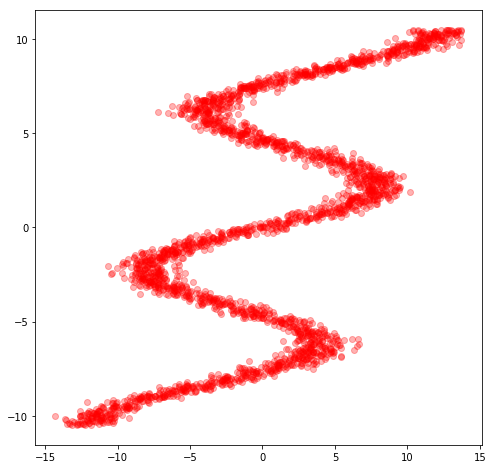

In [13]:
NSAMPLE = 2500

y_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE,1))) # random noise
x_data = np.float32(np.sin(0.75*y_data)*7.0+y_data*0.5+r_data*1.0)

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', alpha=0.3)
plt.show()

$((y-mu)*(1/sigma)) * (1/pi^2) $

In [14]:
oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi) # normalisation factor for gaussian, not needed.
def tf_normal(y, mu, sigma):
    result = tf.subtract(y, mu)
    result = tf.multiply(result,tf.reciprocal(sigma))
    result = -tf.square(result)/2
    return tf.multiply(tf.exp(result),tf.reciprocal(sigma))*oneDivSqrtTwoPI

def get_lossfunc(out_pi, out_sigma, out_mu, y):
    result = tf_normal(y, out_mu, out_sigma)
    result = tf.multiply(result, out_pi)
    result = tf.reduce_sum(result, 1, keep_dims=True)
    result = -tf.log(result)
    return tf.reduce_mean(result)

lossfunc = get_lossfunc(out_pi, out_sigma, out_mu, y)
train_op = tf.train.AdamOptimizer().minimize(lossfunc)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [15]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

NEPOCH = 10000
loss = np.zeros(NEPOCH) # store the training progress here.
for i in range(NEPOCH):
    sess.run(train_op,feed_dict={x: x_data, y: y_data})
    loss[i] = sess.run(lossfunc, feed_dict={x: x_data, y: y_data})

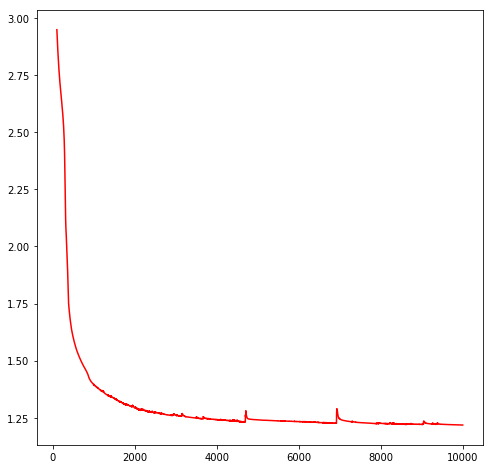

In [16]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(100, NEPOCH,1), loss[100:], 'r-')
plt.show()

In [17]:
x_test = np.float32(np.arange(-15,15,0.1))
NTEST = x_test.size
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector


def get_pi_idx(x, pdf):
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    print('error with sampling ensemble')
    return -1

def generate_ensemble(out_pi, out_mu, out_sigma, M = 10):
    NTEST = x_test.size
    result = np.random.rand(NTEST, M) # initially random [0, 1]
    rn = np.random.randn(NTEST, M) # normal random matrix (0.0, 1.0)
    mu = 0
    std = 0
    idx = 0

  # transforms result into random ensembles
    for j in range(0, M):
        for i in range(0, NTEST):
            idx = get_pi_idx(result[i, j], out_pi[i])
            mu = out_mu[i, idx]
            std = out_sigma[i, idx]
            result[i, j] = mu + rn[i, j]*std
    return result

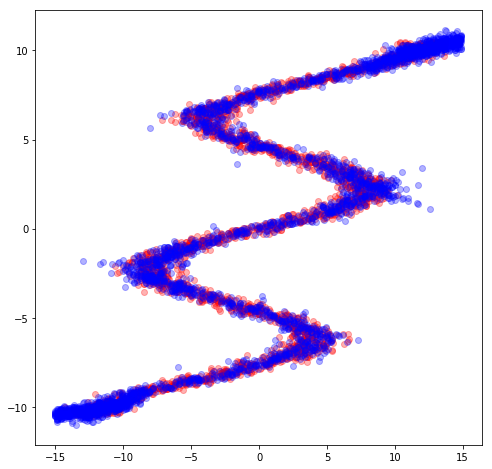

In [18]:
out_pi_test, out_sigma_test, out_mu_test = sess.run(get_mixture_coef(output), feed_dict={x: x_test})

y_test = generate_ensemble(out_pi_test, out_mu_test, out_sigma_test)

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()


In [24]:

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

x = tf.constant([[1, 1, 1], [1, 2, 1]])
val = tf.constant(5.0)
op = tf.reduce_max(x,1)  # 6
rec = tf.reciprocal(val)
tf.reduce_sum(x, 0)  # [2, 2, 2]
tf.reduce_sum(x, 1)  # [3, 3]
tf.reduce_sum(x, 1, keepdims=True)  # [[3], [3]]
tf.reduce_sum(x, [0, 1])  # 6
val = sess.run(op)
print(val)
sess.close()

[1 2]
